In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from scipy.stats import poisson
import pyodbc
from heapq import nlargest
from statistics import mean
import operator

In [2]:
def connection():
        server = '79.175.132.125,1410'
        database = 'express_db'
        username = 'ExpressAnalyst'
        password = '^cVGXN6q[nY#[-GE'
        Driver = 'SQL Server'
        cnxn = pyodbc.connect(
                'DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)
        cursor = cnxn.cursor()
        return cursor 

In [3]:
class Fetch:
    def __init__(self , date , n_day= 7):
        self.date = date
        self.n_day = n_day
    
    def connection(self):
        server = '79.175.132.125,1410'
        database = 'express_db'
        username = 'ExpressAnalyst'
        password = '^cVGXN6q[nY#[-GE'
        Driver = 'SQL Server'
        cnxn = pyodbc.connect(
                'DRIVER={SQL Server};SERVER=' + server + ';DATABASE=' + database + ';UID=' + username + ';PWD=' + password)
        self.cursor = cnxn.cursor()
        return self.cursor
        
    def fetch_data(self):
            start_date = self.date 
            end_date = start_date + dt.timedelta(1)
            end_date_str=end_date.strftime('%Y-%m-%d' )
            start_date_str= start_date.strftime('%Y-%m-%d')
        
            query = f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
                    where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
                    group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
                    order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
            cursor=connection()
            cursor.execute(query)
            online_data=cursor.fetchall()
            df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ])
            df['filt_t'] = df['trips'].rolling(60).mean()
            df.fillna(0)
            self.df = df
            return self.df
                  
    def check_day(self , input_day):
        
        date = input_day.strftime('%m/%d/%Y')
        
        day = str(int(date.split('/')[1]))
        month = str(int(date.split('/')[0]))
        year = date.split('/')[2]

        date = f'{month}/{day}/{year}'


        query_3 = f""" select * from Analytics..Express_PersianCalendar1400 c
                    where c.Miladi_Date = '{date}' """

        cursor=connection()
        cursor.execute(query_3)
        online_data=cursor.fetchall()
        status = pd.DataFrame.from_records( online_data , columns = ['_' , '_' , 'day name' , '_' , 'miladi date' , '_' , 'status' , '_'])

        return status['status'][0]
    
    def similar_dates(self):
        list_of_similar = []
        for i in range(1,20):
            j = self.date + dt.timedelta(i)
            if self.check_day(j)==self.check_day(self.date) and len(list_of_similar) < self.n_day:
                list_of_similar.append(j.date())
            else:
                pass
        self.list_of_similar = list_of_similar
        return self.list_of_similar  
    
    def lam(self):
    
        self.all_lambda = {}
        for day in self.list_of_similar:

            start_date = day 
            end_date = start_date + dt.timedelta(1)
            end_date_str=end_date.strftime('%Y-%m-%d' )
            start_date_str= start_date.strftime('%Y-%m-%d')


            query = f"""select datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at) as sec , count(distinct t.id) as trips from express_db..trip t
                    where t.created_at >= '{start_date_str}' and t.created_at < '{end_date_str}' and t.city_id = 1 and client_id <> 14
                    group by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)
                    order by datepart(hour , t.created_at)*3600 + datepart(minute , t.created_at)*60 + datepart(second ,t.created_at)"""
            cursor=connection()
            cursor.execute(query)
            online_data=cursor.fetchall()
            df = pd.DataFrame.from_records( online_data , columns = ['time' , 'trips' ])
            df['filt_t'] = df['trips'].rolling(60).mean()
            df.fillna(0)

            #print(df.head(5))
            time_range = list(range(27000 ,86400 ,600 )) # 7:30 ~ 24
            for i in range(0 , len(time_range)-1):
                filt = (df['time'] >= time_range[i] ) & (df['time']< time_range[i+1])
                lam = df[filt]['trips'].mean()
                lam = np.round(lam , 3)

                self.all_lambda.setdefault(time_range[i] , [lam]) 
                self.all_lambda[time_range[i]] += [lam]

        self.mean_lambda={}
        for i in self.all_lambda.keys():
            self.mean_lambda.setdefault(i ,np.round(mean(self.all_lambda[i]) , 1))

        self.limit_lambda={}
        for i in self.all_lambda.keys():
            self.limit_lambda.setdefault(i , [max(self.all_lambda[i]) , min(self.all_lambda[i])])

        return self.all_lambda , self.mean_lambda , self.limit_lambda
    
    def
    
    

        
    

In [5]:
class Visual:
    def __init__(self , all_lambda=None , mean_lambda= None , limit_lambda = None , df= None):
        self.all_lambda = all_lambda
        self.mean_lambda = mean_lambda
        self.limit_lambda = limit_lambda
        self.df = df
    
    def visualization(self):
        ma = [self.limit_lambda[i][0] for i in self.limit_lambda.keys()]
        mi = [self.limit_lambda[i][1] for i in self.limit_lambda.keys()]
        fig = plt.figure(figsize=(12,10))
        ax= plt.plot(  self.df['time'] , self.df['trips'])
        ax2 = plt.plot(self.df['time'] , self.df['filt_t'] ,alpha = 0.9)
        ax3 = plt.plot(self.mean_lambda.keys() , self.mean_lambda.values() ,c='black')
        ax4 = plt.plot(self.limit_lambda.keys() , ma , c='r',linewidth=2.5)
        ax5 = plt.plot(self.limit_lambda.keys() , mi ,c='#17becf' ,linewidth=2.5)

In [8]:
base = dt.datetime.today()-dt.timedelta(200)
date_range = [base - dt.timedelta(x) for x in range(1,10)]
 

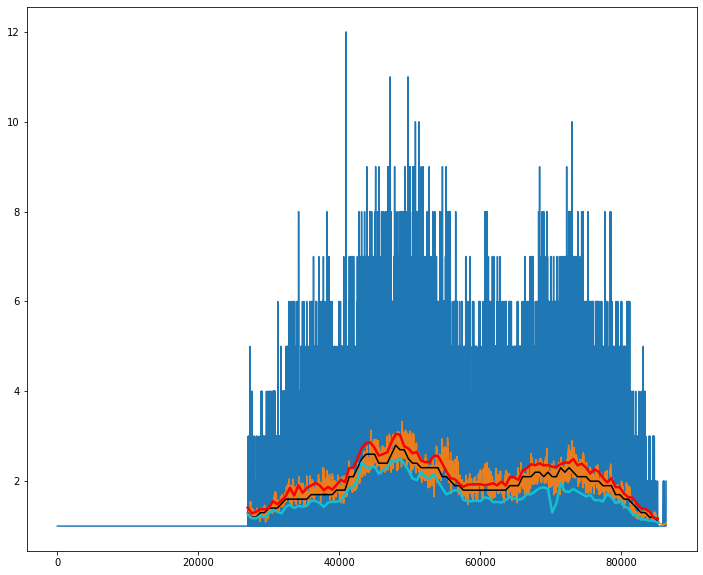

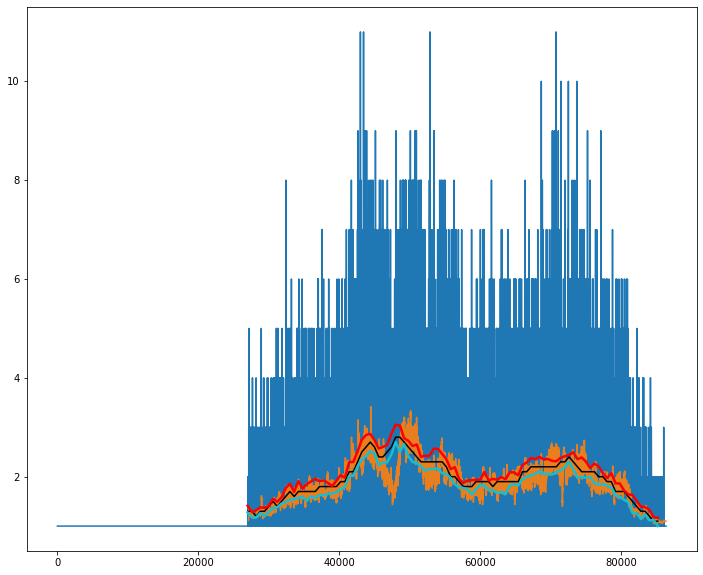

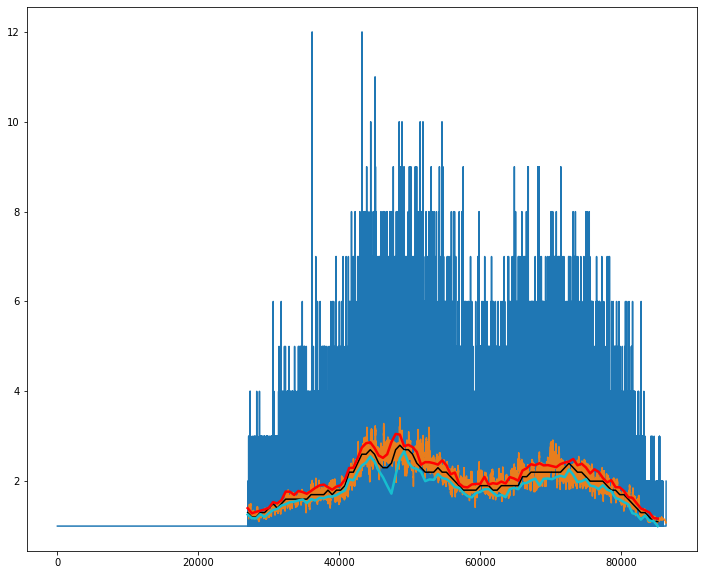

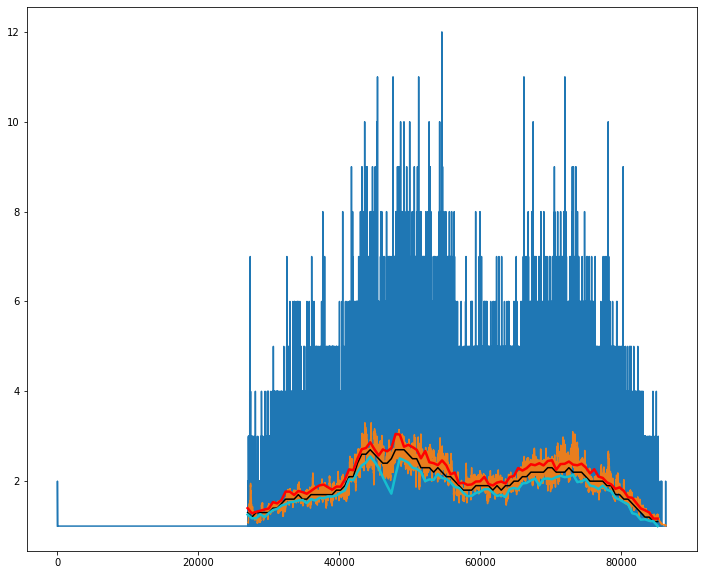

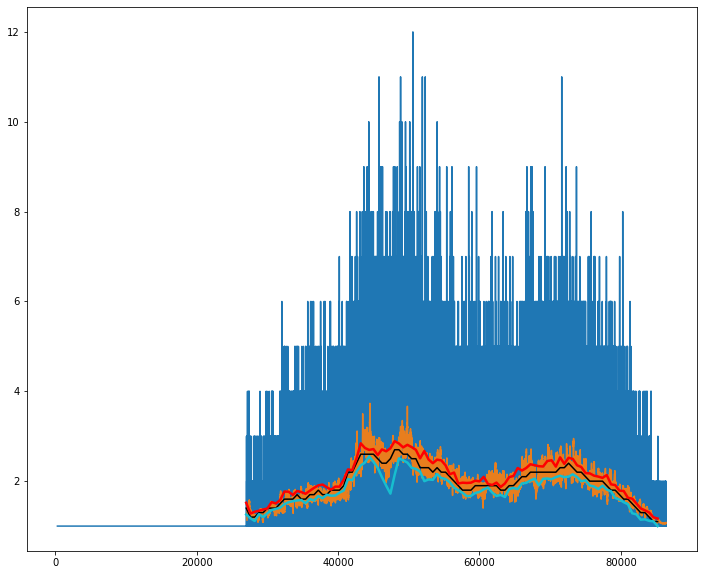

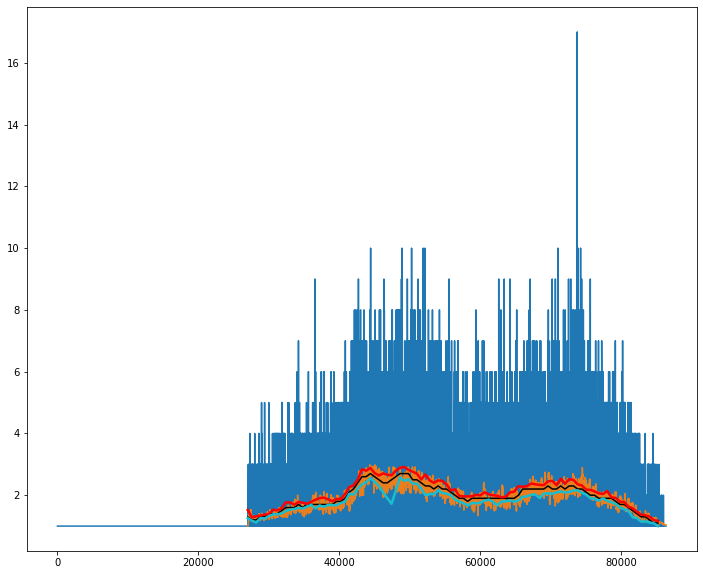

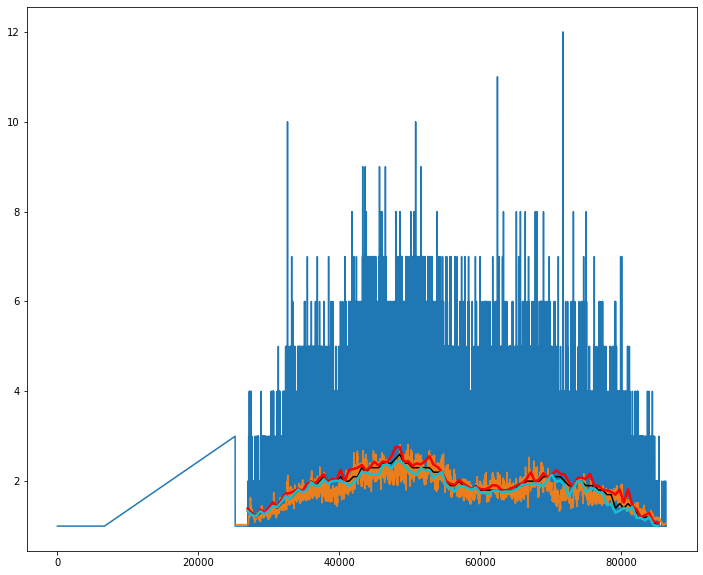

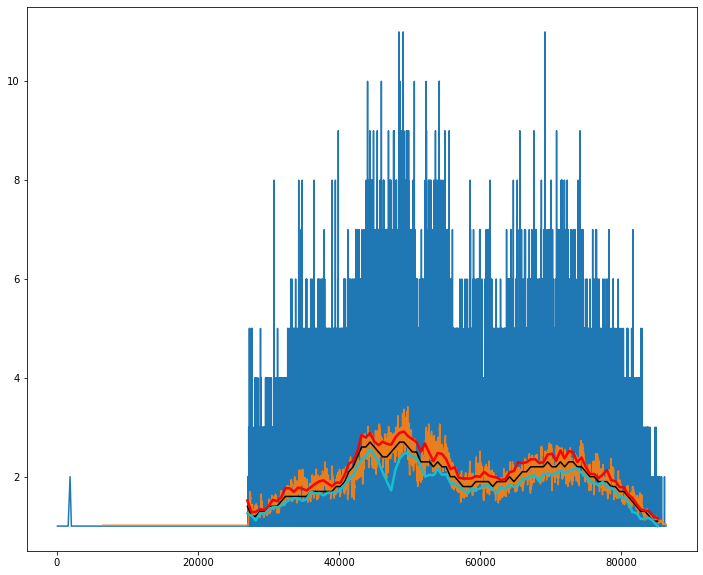

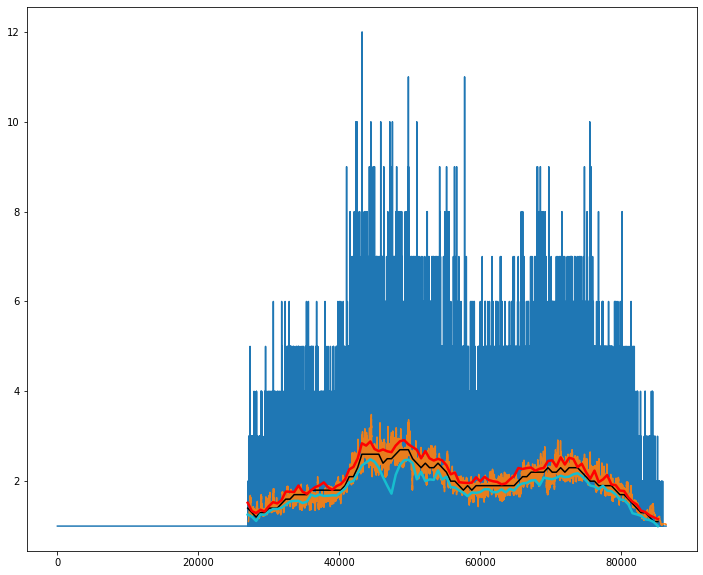

In [9]:
for i in date_range:
    fetch = Fetch(i)
    df= fetch.fetch_data()
    sim_day = fetch.similar_dates()
    all_lambda , mean_lambda , limit_lambda = fetch.lam()
    visual = Visual (all_lambda = all_lambda,mean_lambda=mean_lambda,limit_lambda=limit_lambda,df=df)
    visual.visualization()  

In [ ]:
fetch = Fetch(dt.datetime.today()-dt.timedelta(140))
df= fetch.fetch_data()
sim_day = fetch.similar_dates()
all_lambda , mean_lambda , limit_lambda = fetch.lam()
visual = Visual (all_lambda = all_lambda,mean_lambda=mean_lambda,limit_lambda=limit_lambda,df=df)
visual.visualization()